In [15]:
import pandas as pd
import numpy as np
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
from loguru import logger

In [16]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
os.chdir(os.environ.get("ROOT_DIR"))
from src import DATA_DIR


In [17]:
clusters = pd.read_csv(DATA_DIR / 'processed' / 'sg_clusters.csv')

In [18]:
places = pd.read_csv(DATA_DIR / 'processed' / 'philly_places.csv.tar.gz', low_memory = False)

In [19]:
def get_last_vals(df, vals, id_col, date_col):
    df = df[vals + [id_col, date_col]].dropna()
    df = df.sort_values(date_col, ascending = False)
    df = df.drop(columns = date_col)
    return df.groupby(id_col).first().reset_index()

In [20]:
value_sets = [['latitude','longitude'], ['brands'], ['top_category']]
id_col = 'safegraph_place_id'
date_col = 'valid_from'
for vals in value_sets:
    values = get_last_vals(places, vals, id_col, date_col)
    clusters = clusters.merge(values, on = 'safegraph_place_id', how = 'left')

In [21]:
clusters

safegraph_place_id  cluster   latitude  longitude  \
0      sg:00018e7b1ba449278dd1c33a2348e5fa        1  40.106492 -75.029052   
1      sg:0001da921b9d488986c0bdf83bfaff4b        1  40.102114 -75.031340   
2      sg:0003e5a379604393b0dc6e9bce0058b2        5  39.982305 -75.239359   
3      sg:0004189674c64e108e4b5ea2baa68eb9        1  39.924732 -75.169153   
4      sg:0008547f38f54091836959120205256c       10  39.974429 -75.141649   
...                                    ...      ...        ...        ...   
19642  sg:fff63ed550f040d3abb82f1cf68f3420        1  39.929090 -75.146995   
19643  sg:fffa1e4de2334d4aaefeabf8a4ecd8a0       10  40.036797 -75.130750   
19644  sg:fffd2de0819b46b2894b5ffb13122128        1  39.963748 -75.167991   
19645  sg:fffe3d31062f46d9a2a0b0eca6d0c585        1  39.946316 -75.148319   
19646  sg:fffeeeeb4945428b88f842efe5366d7d        8  40.023017 -75.075921   

                          brands  \
0                            NaN   
1                            NaN   
2                 Little Caesars   
3      Popeyes Louisiana Kitchen   
4                            NaN   
...                          ...   
19642                     DaVita   
19643                        NaN   
19644                        NaN   
19645                        NaN   
19646                  Walgreens   

                                         top_category  
0                 Restaurants and Other Eating Places  
1      Automotive Parts, Accessories, and Tire Stores  
2                 Restaurants and Other Eating Places  
3                 Restaurants and Other Eating Places  
4                    Elementary and Secondary Schools  
...                                               ...  
19642                         Outpatient Care Centers  
19643                                  Grocery Stores  
19644                         Child Day Care Services  
19645           Offices of Other Health Practitioners  
19646                 Health and Personal Care Stores  

[19647 rows x 6 columns]

In [59]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import hvplot.pandas
import geopandas as gpd
import urllib.request
import json
from matplotlib import pyplot as plt
import panel as pn
import param as pm

In [41]:
big_brands = clusters.groupby('brands').size().sort_values(ascending = False).index[:5]

In [42]:
brand_data = clusters[clusters.brands.apply(lambda x: x in big_brands)]

In [43]:
brand_data = brand_data.groupby(['brands','cluster']).size().reset_index()

In [44]:
brand_data.columns = [col for col in brand_data.columns[:2]] + ['count']

In [47]:
brand_data['total'] = brand_data[['brands','count']].groupby('brands').transform('sum')

In [49]:
brand_data['frequency'] = brand_data['count']/brand_data['total']

In [68]:
brands_df = brand_data[['brands']].drop_duplicates()
clusters_df = brand_data[['cluster']].drop_duplicates()
brands_df['key'] = 1
clusters_df['key'] = 1
combined_df = brands_df.merge(clusters_df)
combined_df.drop(columns = 'key', inplace = True)
brand_data = combined_df.merge(brand_data, on = ['cluster','brands'], how = 'left')
brand_data = brand_data.fillna(0)

<BarContainer object of 6 artists>

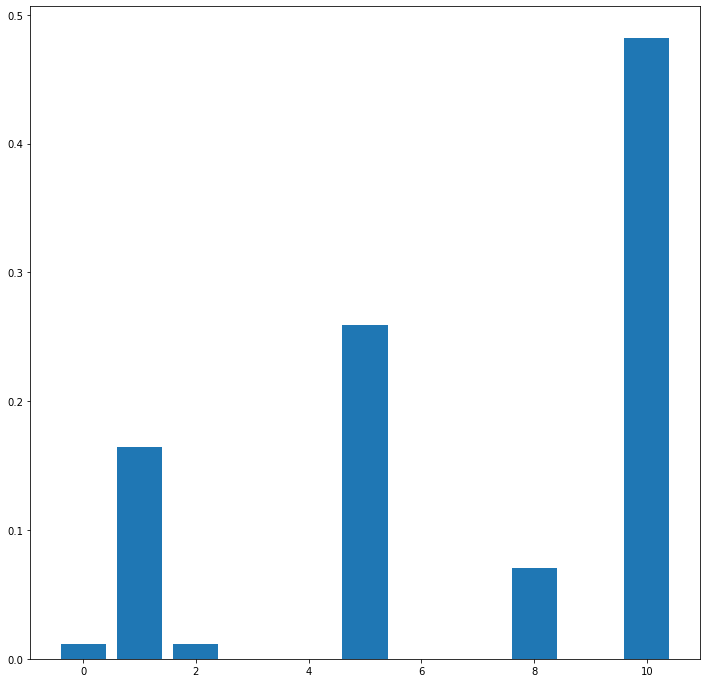

In [57]:
brand = big_brands[1]
plot_data = brand_data[brand_data['brands'] == brand]
fig, ax = plt.subplots(figsize=(12, 12))

ax.bar(plot_data.cluster, plot_data.frequency)

In [69]:
# HK: I would like to have checkboxes for 'normalized by devices seen' and 'relative to January'
#     but don't know how to give the checkbox a name (I was looking at pm.Boolean()).
class Brand_distribution(pm.Parameterized):
    df = brand_data
    brand = pm.Selector(
        objects = big_brands,
        default = big_brands[0], allow_None = False)
    
    @pm.depends('brand')
    def make_subtitle(self):
        return 'Distribution of ' + self.brand + ' locations by cluster'
    
    @pm.depends('df', 'brand')
    def filter_brand(self):
        mask = self.df['brands'] == self.brand
        return self.df.loc[mask]
        
    @pm.depends('df', 'brand')
    def make_bar_plot(self):
        n_clusters = max(self.df.cluster)
        filtered = self.filter_brand()
        #return filtered[['svcg_cycle_date', 'pct_missing']].hvplot(kind='line')
        # Create the figure
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Plot
        ax.bar(filtered.cluster, filtered.frequency)

        # NEW: Set the xlims and ylims
        ax.set_xlim(-1, n_clusters+1)
        ax.set_ylim(0, 1)

        return fig

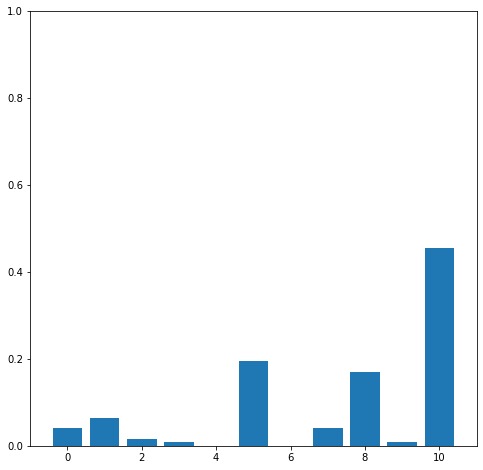

In [70]:
brand_app = Brand_distribution(name = "")
brand_title = '### Brands by cluster'
brand_panel = pn.Column(
    pn.Row(
        pn.Column(brand_title, brand_app.make_subtitle, pn.Param(brand_app.param))
    ), brand_app.make_bar_plot )

Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] ParamMethod(method)
            [2] Param(Brand_distribution)
    [1] ParamMethod(method)
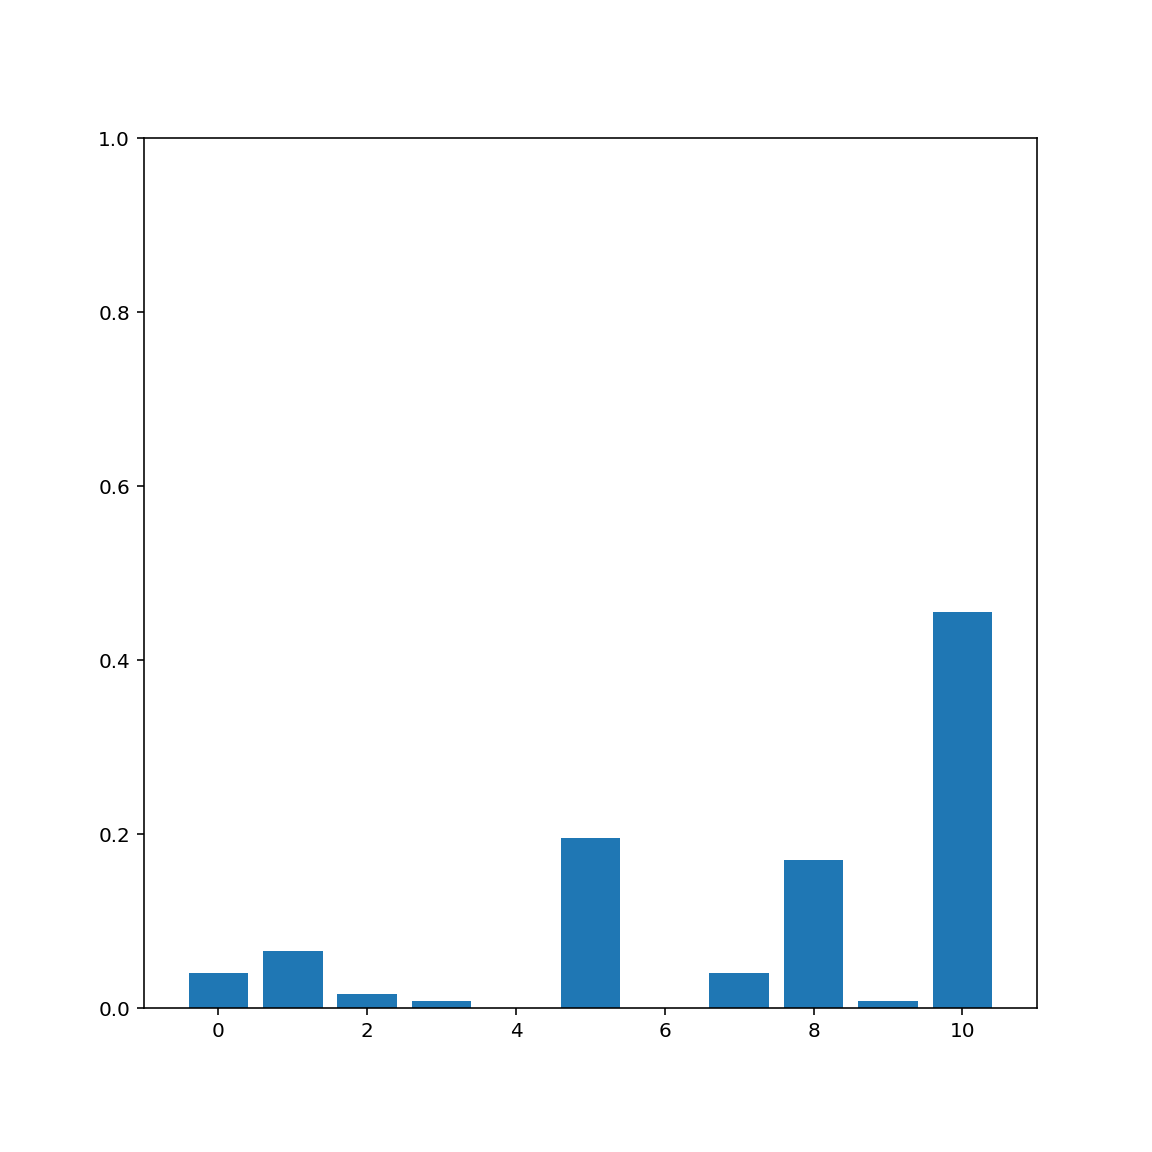

In [71]:
brand_panel

In [8]:
places.sort_values('valid_from', ascending = False)

safegraph_place_id  \
64304  sg:ca990f5fb4514cc8b966b3c6e744c3dc   
71239  sg:dfc52f5da0ca4555a7e0803a9dd7b8a7   
71241  sg:fda07b7e2ab14e83ad93aeae7f387139   
71242  sg:073eb2dbebc54464b56d04348e41f77b   
71243  sg:22f9aae979644a93b9dda3ba8540cbf5   
...                                    ...   
14382  sg:53ee6625c239407b8674fbfeb3327777   
14383  sg:9d71dfeae49a4bd1a9bc672af75aa4bf   
14384  sg:a444d6a14d8445a2a901c13ff75d1e0b   
14385  sg:b4b9c7be257242a1b4544826c5bc7dd2   
0      sg:13ff95596a514499a0edbc3d45e7ad98   

                 parent_safegraph_place_id  \
64304  sg:4e063fa72f97420b8fc99c2b6bbe852d   
71239                                  NaN   
71241  sg:22feac29c893479cbd20db580ba5b839   
71242                                  NaN   
71243                                  NaN   
...                                    ...   
14382                                  NaN   
14383                                  NaN   
14384                                  NaN   
14385                                  NaN   
0                                      NaN   

                            location_name  \
64304                             Staples   
71239                        Mick Daniels   
71241                       Health Street   
71242                        Goorin Bros.   
71243      Bridge & Pratt Family Pharmacy   
...                                   ...   
14382                      Rizzo Ice Rink   
14383         All Saints Episcopal School   
14384          Munlyns Munchkins Day Care   
14385     Little Learners Learning Center   
0      Pentecostal Church of Philadelphia   

                             safegraph_brand_ids         brands  \
64304  SG_BRAND_a4d18fc84a927940d1294e253001ce3d        Staples   
71239                                        NaN            NaN   
71241                  SG_BRAND_c5c154df3c9599e7  Health Street   
71242                   SG_BRAND_fae48665591f2eb   Goorin Bros.   
71243                                        NaN            NaN   
...                                          ...            ...   
14382                                        NaN            NaN   
14383                                        NaN            NaN   
14384                                        NaN            NaN   
14385                                        NaN            NaN   
0                                            NaN            NaN   

                                       top_category  \
64304  Office Supplies, Stationery, and Gift Stores   
71239         Drinking Places (Alcoholic Beverages)   
71241           Medical and Diagnostic Laboratories   
71242                               Clothing Stores   
71243               Health and Personal Care Stores   
...                                             ...   
14382     Other Amusement and Recreation Industries   
14383              Elementary and Secondary Schools   
14384                                           NaN   
14385              Elementary and Secondary Schools   
0                           Religious Organizations   

                                  sub_category  naics_code   latitude  \
64304    Office Supplies and Stationery Stores    453210.0  40.031024   
71239    Drinking Places (Alcoholic Beverages)    722410.0  39.921971   
71241                     Medical Laboratories    621511.0  39.926347   
71242                    Other Clothing Stores    448190.0  39.949651   
71243               Pharmacies and Drug Stores    446110.0  40.021572   
...                                        ...         ...        ...   
14382  Fitness and Recreational Sports Centers    713940.0  39.933165   
14383         Elementary and Secondary Schools    611110.0  40.058462   
14384                                      NaN         NaN  39.961807   
14385         Elementary and Secondary Schools    611110.0  40.050319   
0                      Religious Organizations    813110.0  40.053464   

       longitude  ...  phone_numbe

In [7]:
places.valid_from.unique()

array(['2020-09-08', '2020-08-07', '2020-07-13', '2020-06-06',
       '2020-05-06', '2020-04-07', '2020-03-25', '1900-01-01'],
      dtype=object)

In [8]:
places = places.groupby('safegraph_place_id').first().reset_index()

In [9]:
places.groupby('valid_from').size()

valid_from
1900-01-01       95
2020-03-25      512
2020-04-07       68
2020-05-06      192
2020-06-06     3050
2020-07-13      599
2020-08-07      224
2020-09-08    21076
dtype: int64

In [10]:
places.head()

safegraph_place_id            parent_safegraph_place_id  \
0  sg:0000395ed3954bf6bce9fc48d52f3c5b                                 None   
1  sg:00018e7b1ba449278dd1c33a2348e5fa                                 None   
2  sg:0001da921b9d488986c0bdf83bfaff4b                                 None   
3  sg:0003e5a379604393b0dc6e9bce0058b2  sg:e61ba782d68d41f58ea5ef4cdde0565b   
4  sg:0004189674c64e108e4b5ea2baa68eb9                                 None   

               location_name                        safegraph_brand_ids  \
0               Lanci Bakery                                       None   
1            Maxi Gastronome                                       None   
2     Carlo's Tire & Repairs                                       None   
3             Little Caesars  SG_BRAND_3654ed70612445d52bf3b6f6546d1f23   
4  Popeyes Louisiana Kitchen  SG_BRAND_5725c57624e4d885d0bf718123615aa9   

                      brands                                    top_category  \
0                       None             Bakeries and Tortilla Manufacturing   
1                       None             Restaurants and Other Eating Places   
2                       None  Automotive Parts, Accessories, and Tire Stores   
3             Little Caesars             Restaurants and Other Eating Places   
4  Popeyes Louisiana Kitchen             Restaurants and Other Eating Places   

                              sub_category  naics_code   latitude  longitude  \
0                          Retail Bakeries    311811.0  39.923647 -75.175465   
1                 Full-Service Restaurants    722511.0  40.106492 -75.029052   
2  Automotive Parts and Accessories Stores    441310.0  40.102114 -75.031340   
3              Limited-Service Restaurants    722513.0  39.982305 -75.239359   
4              Limited-Service Restaurants    722513.0  39.924732 -75.169153   

   ...  phone_number                                         open_hours  \
0  ...  1.215463e+10                                               None   
1  ...           NaN  { "Mon": [["9:00", "20:00"]], "Tue": [["9:00",...   
2  ...  1.215465e+10  { "Mon": [["8:00", "17:00"]], "Tue": [["8:00",...   
3  ...  1.215878e+10                                               None   
4  ...  1.215334e+10                                               None   

                                  category_tags    valid_to  valid_from  \
0                                          None  2020-07-13  2020-06-06   
1                    Russian Food,European Food  2020-10-19  2020-09-08   
2                                          None  2020-10-19  2020-09-08   
3  Counter Service,Pizza,Lunch,Fast Food,Dinner  2020-10-19  2020-09-08   
4          Fried Chicken,Fast Food,Lunch,Dinner  2020-10-19  2020-09-08   

              placekey opened_on closed_on tracking_opened_since  \
0                 None      None   2020-01                  None   
1  225-222@628-p9p-tgk      None      None                  None   
2  zzw-223@628-p9p-qmk      None      None                  None   
3  222-222@628-ph5-qcq      None      None               2020-01   
4  227-222@628-pm4-gtv      None      None                  None   

  tracking_closed_since  
0               2019-07  
1               2019-07  
2               2019-07  
3               2019-07  
4               2019-07  

[5 rows x 25 columns]

In [11]:
clusters.head()

safegraph_place_id  cluster
0  sg:00018e7b1ba449278dd1c33a2348e5fa        1
1  sg:0001da921b9d488986c0bdf83bfaff4b        1
2  sg:0003e5a379604393b0dc6e9bce0058b2        5
3  sg:0004189674c64e108e4b5ea2baa68eb9        1
4  sg:0008547f38f54091836959120205256c       10

### Convert to geo df

In [17]:
clusters = clusters.dropna(subset=['latitude', 'longitude'])

In [19]:
clusters['Coordinates'] = list(zip(clusters['longitude'], clusters['latitude']))

In [20]:
clusters['Coordinates'].head()

0    (-75.029052, 40.106492)
1     (-75.03134, 40.102114)
2    (-75.239359, 39.982305)
3    (-75.169153, 39.924732)
4    (-75.141649, 39.974429)
Name: Coordinates, dtype: object

In [21]:
from shapely.geometry import Point
clusters['Coordinates'] = clusters['Coordinates'].apply(Point)

In [22]:
clusters = gpd.GeoDataFrame(clusters, geometry="Coordinates", crs={"init": "epsg:4326"})

//anaconda3/envs/safegraph/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [23]:
clusters = clusters.to_crs(epsg=3857)

In [25]:
city_limits = gpd.read_file(DATA_DIR / 'raw' / 'City_Limits')
city_limits = city_limits.to_crs(epsg=3857)

In [35]:
clusters = gpd.sjoin(clusters, city_limits, op='within')


In [36]:
import contextily as ctx

In [37]:
clusters.head()

safegraph_place_id  cluster  \
0  sg:00018e7b1ba449278dd1c33a2348e5fa        1   
1  sg:0001da921b9d488986c0bdf83bfaff4b        1   
2  sg:0003e5a379604393b0dc6e9bce0058b2        5   
3  sg:0004189674c64e108e4b5ea2baa68eb9        1   
4  sg:0008547f38f54091836959120205256c       10   

             parent_safegraph_place_id              location_name  \
0                                 None            Maxi Gastronome   
1                                 None     Carlo's Tire & Repairs   
2  sg:e61ba782d68d41f58ea5ef4cdde0565b             Little Caesars   
3                                 None  Popeyes Louisiana Kitchen   
4                                 None    Al Aqsa Islamic Academy   

                         safegraph_brand_ids                     brands  \
0                                       None                       None   
1                                       None                       None   
2  SG_BRAND_3654ed70612445d52bf3b6f6546d1f23             Little Caesars   
3  SG_BRAND_5725c57624e4d885d0bf718123615aa9  Popeyes Louisiana Kitchen   
4                                       None                       None   

                                     top_category  \
0             Restaurants and Other Eating Places   
1  Automotive Parts, Accessories, and Tire Stores   
2             Restaurants and Other Eating Places   
3             Restaurants and Other Eating Places   
4                Elementary and Secondary Schools   

                              sub_category  naics_code   latitude  ...  \
0                 Full-Service Restaurants    722511.0  40.106492  ...   
1  Automotive Parts and Accessories Stores    441310.0  40.102114  ...   
2              Limited-Service Restaurants    722513.0  39.982305  ...   
3              Limited-Service Restaurants    722513.0  39.924732  ...   
4         Elementary and Secondary Schools    611110.0  39.974429  ...   

              placekey opened_on closed_on tracking_opened_since  \
0  225-222@628-p9p-tgk      None      None                  None   
1  zzw-223@628-p9p-qmk      None      None                  None   
2  222-222@628-ph5-qcq      None      None               2020-01   
3  227-222@628-pm4-gtv      None      None                  None   
4  23d-222@628-pnx-rkz      None      None                  None   

   tracking_closed_since                       Coordinates  index_right  \
0                2019-07  POINT (-8352195.863 4881429.496)            0   
1                2019-07  POINT (-8352450.562 4880792.322)            0   
2                2019-07  POINT (-8375607.131 4863371.223)            0   
3                2019-07  POINT (-8367791.835 4855010.560)            0   
4                2019-07  POINT (-8364730.104 4862227.067)            0   

  OBJECTID Shape__Are Shape__Len  
0        1   0.038911   1.259687  
1        1   0.038911   1.259687  
2        1   0.038911   1.259687  
3        1   0.038911   1.259687  
4        1   0.038911   1.259687  

[5 rows x 31 columns]

//anaconda3/envs/safegraph/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  del sys.path[0]


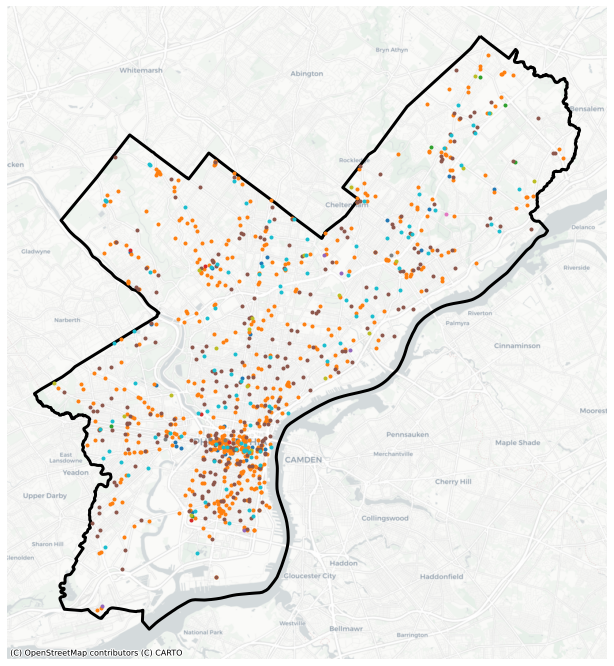

In [38]:

# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# add the city limits
city_limits.to_crs(clusters.crs).plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# plot a random sample of potholes
groups = clusters.sample(1000).groupby('cluster')
for name, group in groups:
    group.plot(ax=ax, marker='.')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=clusters.crs, url=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()